In [10]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader
from skimage.measure import compare_ssim, compare_mse
from sklearn.preprocessing import RobustScaler
from monai.networks.nets import UNet

%autoreload 2
from networks import *
from utils import set_device, set_seed
from losses import AWLoss
from datasets import UndersampledUltrasoundDataset3D


import matplotlib.pyplot as plt
import progressbar
import plotly.express as px
import plotly.graph_objects as go

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training Setup

In [11]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=1200
dims_latent = 32                            
learning_rate=1e-3
batch_size=4                                        
device=set_device("cuda", 0)


# Losses
l2loss     = nn.MSELoss(reduction="sum")
awloss     = AWLoss(filter_dim=2, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)


Cuda installed! Running on GPU 0 NVIDIA GeForce RTX 2080 Ti!


# MRI Dataset 

In [13]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def resize(x, nc, h, w):
    return torch.nn.functional.interpolate(x.unsqueeze(0).unsqueeze(0), size=(nc, h, w)).squeeze(0).squeeze(0)

def robust_scalar(x):
    shape = x.shape
    rs = RobustScaler()
    x = rs.fit_transform(x.flatten(start_dim=1))
    return torch.tensor(x.reshape(shape), dtype=torch.float32)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x



{'name': 'UndersampledUltrasoundDataset3D', 'path': '/media/dekape/HDD/Ultrasound-MRI_volumes', 'maxsamples': 16, 'transform': Compose(
    Lambda()
    Lambda()
    Lambda()
), 'undersample_width': (1, 1, 2), 'mode': 'mri', 'fill': 0.0, 'len': 16} 

torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


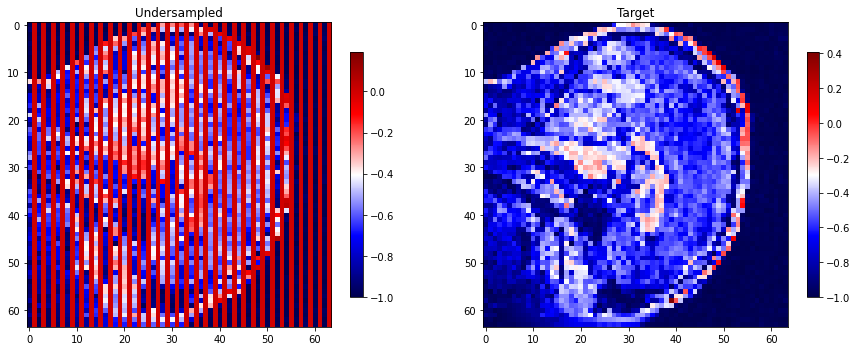

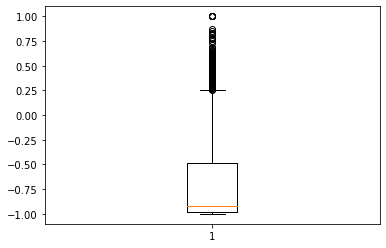

{'max': tensor(1.),
 'min': tensor(-1.),
 'mean': tensor(-0.3589),
 'std': tensor(0.4422),
 'shape': torch.Size([64, 64, 64])}

In [14]:
# Dataset
path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI_volumes/")
train_transform = Compose([
                    Lambda(lambda x: resize(x, 64, 64, 64)),
                    # Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x)),
                    # Lambda(lambda x: robust_scalar(x)),
                    Lambda(lambda x: scale2range(x, [-1, 1])),
                    # Normalize(0., 1.),
                    ])
trainds = UndersampledUltrasoundDataset3D(path, 
                                        mode="mri",
                                        transform=train_transform,
                                        undersample_width=(1,1,2),
                                        maxsamples=16)
print(trainds, "\n")

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

# Sample for visualisation
x_sample, y_sample = trainds[0]
print(x_sample.shape, y_sample.shape)

idx = int(x_sample.shape[0]/2)
vmin, vmax, cmap =  None, None, "seismic"
fig, axs = plt.subplots(1,2, figsize=(15,15))

im = axs[0].imshow(x_sample[idx], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs[0], shrink=0.3)
axs[0].set_title("Undersampled")

im = axs[1].imshow(y_sample[idx], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs[1], shrink=0.3)
axs[1].set_title("Target")
plt.show()

plt.boxplot(y_sample.flatten().numpy())
plt.show()

trainds.info(nsamples=1)

## Model 

In [15]:
def make_model(channels=64):
    return UNet(
    spatial_dims=2,
    in_channels=channels,
    out_channels=channels,
    channels=(16, 32, 64, 128, 256),
    strides=tuple([2 for i in range(channels)]), 
    num_res_units=2,
    act="mish",
).to(device)

print(make_model())

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
      )
      (residual): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (

/home/dekape/miniconda3/lib/python3.7/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 60 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


## Train and Validate Functions

In [16]:
def train(model, train_loader, optimizer, criterion, wmse=0., device="cpu"):
    """ Trains one epoch"""
    model.train()
    
    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="sum")(recon, target)
        combied_loss = loss + wmse*mse

        # Backprop and optim step
        combied_loss.backward()
        optimizer.step()  
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

def validate(model, train_loader, criterion, device="cpu"):
    """ Validates loss of a data loader of an autoencoder """
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        for i , (X, target) in enumerate(train_loader):
            X, target = X.to(device), target.to(device)
            
            # Forward Pass
            recon = torch.tanh(model(X))

            # Evaluate losses
            loss  = criterion(recon, target)
            
            total_loss += loss / len(train_loader)
    return total_loss

# Training

In [17]:
def train_model(model, optimizer, loss, train_loader, wmse=0., valid_loader=None, nepochs=150, log_frequency=10, sample_input=None, sample_target=None, device="cpu"):
    print("\n\nTraining started ...")
    train_losses, valid_losses, mse = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train epoch
            epoch_loss, mse_loss = train(model, train_loader, optimizer, loss, wmse, device)
            # validate
            # ssim score, aco_diff = compare_ssim(ela_real, aco_real, full=True, gaussian_weights=True)
            train_losses.append(epoch_loss.item())
            mse.append(mse_loss.item())
            bar.update(epoch)
            
            # Logging
            log = {"epoch": epoch, "loss": epoch_loss.item(), "mse (weight %.2f)"%wmse:mse_loss}
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                # Figure for plotting
                fig, axs = plt.subplots(2,3, figsize=(15, 15))
                axs = axs.flatten()

                # Plot losses
                axs[0].plot(train_losses, label="train")
                axs[0].plot(valid_losses, label="valid")
                axs[0].legend()
                axs[0].set_title(str(loss))
                axs[0].set_xlabel("epoch")

                axs[1].plot(mse)
                axs[1].set_xlabel("epoch")
                axs[1].set_title("MSE [Loss weight %.2f]"%wmse)

                # Plots
                if sample_input is not None:
                    idx = int(sample_input.shape[0]/2)

                    # Model forward pass
                    model.eval()
                    X = sample_input.unsqueeze(0).to(device)
                    recon = torch.tanh(model(X))[0]

                    # Plot sample input
                    im = axs[3].imshow(sample_input[idx])#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[3], shrink=0.5)
                    axs[3].set_title("Input idx %g"%idx)

                    # Plot reconstruction
                    im = axs[4].imshow(recon[idx].cpu().detach().numpy())#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[4], shrink=0.5)
                    axs[4].set_title("Reconstruction idx %g"%idx)

                    
                    if sample_target is not None:
                        # Plot target input
                        im = axs[5].imshow(sample_target[idx])#, vmin=X.min(), vmax=X.max())
                        fig.colorbar(im, ax=axs[5], shrink=0.5)
                        axs[5].set_title("Target idx %g"%idx)

                        # Loss evaluation and filters
                        print(recon.shape, sample_target.shape)
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        if "awloss" in str(loss).lower():
                            v, T = loss.filters[0], loss.T
                            
                            # Plot filter
                            axs[2].plot(v.flatten().cpu().detach().numpy(), label="Wiener Filter")
                            axs[2].set_ylim(None, 1.1)
                            axs[2].legend()
                            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                        else:
                            pass


            plt.show()



Training started ...


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 906109.0, 'mse (weight 0.00)': tensor(906109., device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


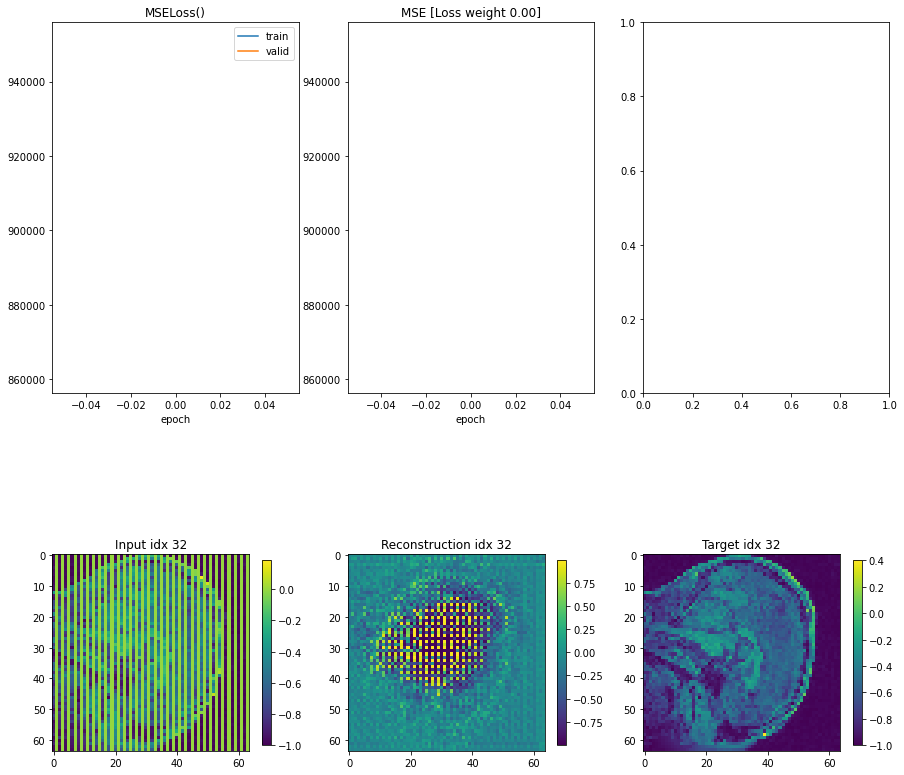

  0% (1 of 150) |                        | Elapsed Time: 0:00:04 ETA:   0:10:02
  1% (2 of 150) |                        | Elapsed Time: 0:00:07 ETA:   0:07:47
  2% (3 of 150) |                        | Elapsed Time: 0:00:10 ETA:   0:07:17
  2% (4 of 150) |                        | Elapsed Time: 0:00:13 ETA:   0:07:15
  3% (5 of 150) |                        | Elapsed Time: 0:00:16 ETA:   0:07:17
  4% (6 of 150) |                        | Elapsed Time: 0:00:19 ETA:   0:07:05
  4% (7 of 150) |#                       | Elapsed Time: 0:00:22 ETA:   0:07:08
  5% (8 of 150) |#                       | Elapsed Time: 0:00:25 ETA:   0:06:57
  6% (9 of 150) |#                       | Elapsed Time: 0:00:28 ETA:   0:07:00
  6% (10 of 150) |#                      | Elapsed Time: 0:00:31 ETA:   0:07:14
  7% (11 of 150) |#                      | Elapsed Time: 0:00:34 ETA:   0:07:17
  8% (12 of 150) |#                      | Elapsed Time: 0:00:37 ETA:   0:06:59
  8% (13 of 150) |#                     


 {'epoch': 149, 'loss': 19994.947265625, 'mse (weight 0.00)': tensor(19994.9473, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


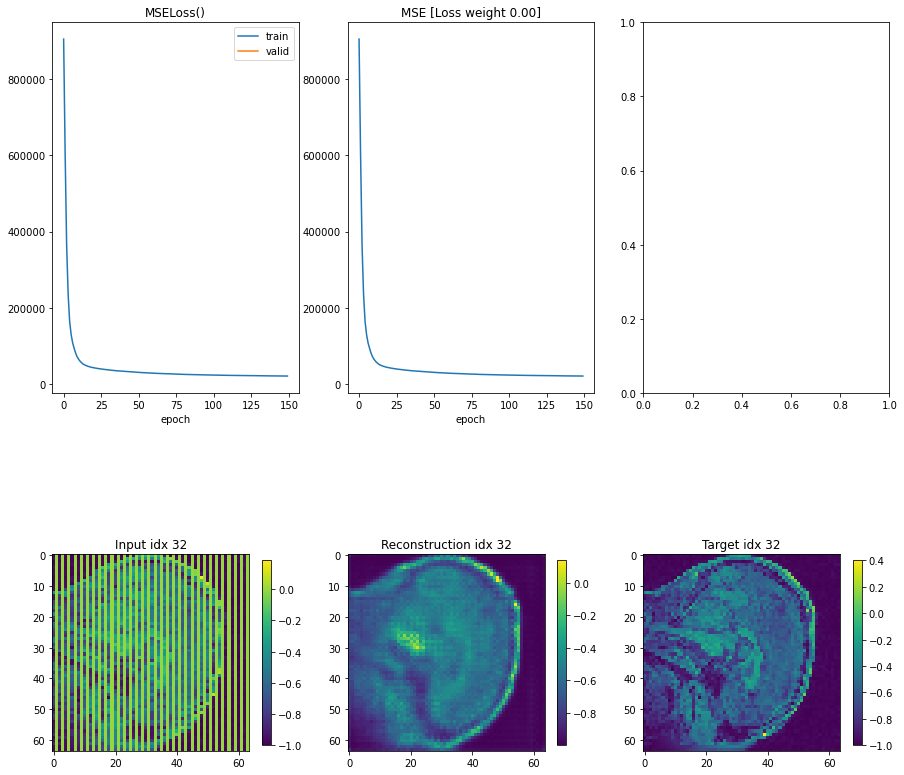

100% (150 of 150) |######################| Elapsed Time: 0:07:31 Time:  0:07:31


In [18]:
model = make_model(channels=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, optimizer, l2loss, train_loader, wmse=0., valid_loader=None, nepochs=150, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)



Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 60 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 1200) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 178.1253204345703, 'mse (weight 0.00)': tensor(1050924.6250, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 778588


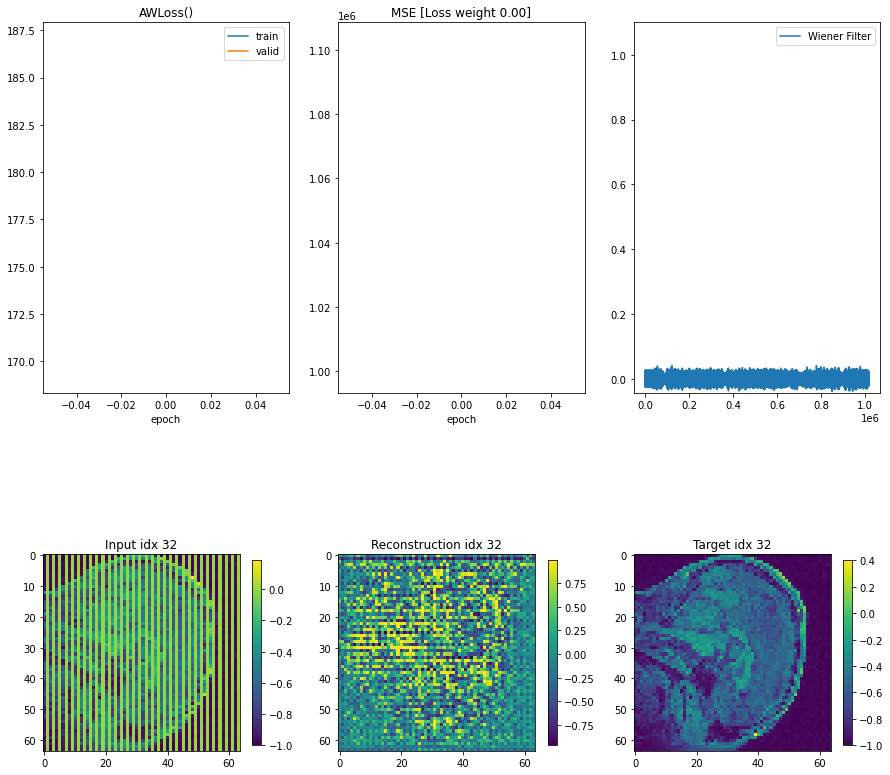

  0% (1 of 1200) |                       | Elapsed Time: 0:00:04 ETA:   1:24:29
  0% (2 of 1200) |                       | Elapsed Time: 0:00:07 ETA:   1:04:18
  0% (3 of 1200) |                       | Elapsed Time: 0:00:10 ETA:   1:02:38
  0% (4 of 1200) |                       | Elapsed Time: 0:00:13 ETA:   1:01:47
  0% (5 of 1200) |                       | Elapsed Time: 0:00:16 ETA:   1:04:08
  0% (6 of 1200) |                       | Elapsed Time: 0:00:20 ETA:   1:02:13
  0% (7 of 1200) |                       | Elapsed Time: 0:00:23 ETA:   1:06:00
  0% (8 of 1200) |                       | Elapsed Time: 0:00:26 ETA:   1:02:00
  0% (9 of 1200) |                       | Elapsed Time: 0:00:29 ETA:   1:01:26
  0% (10 of 1200) |                      | Elapsed Time: 0:00:32 ETA:   1:01:22
  0% (11 of 1200) |                      | Elapsed Time: 0:00:35 ETA:   1:03:01
  1% (12 of 1200) |                      | Elapsed Time: 0:00:39 ETA:   1:04:07
  1% (13 of 1200) |                     


 {'epoch': 1199, 'loss': 134.8745574951172, 'mse (weight 0.00)': tensor(1134036.8750, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 540321


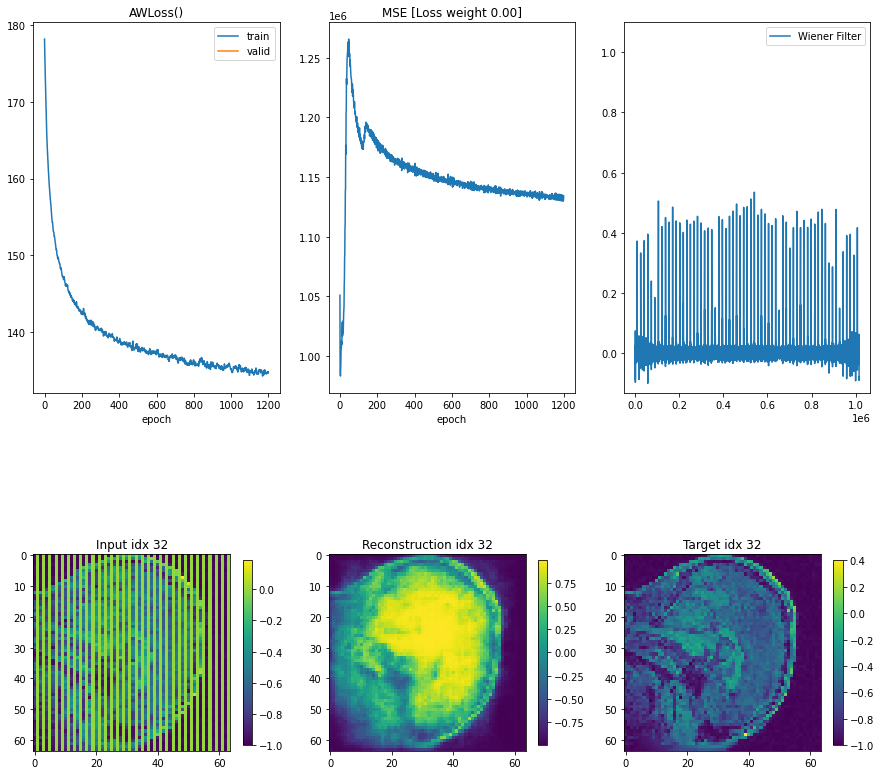

100% (1200 of 1200) |####################| Elapsed Time: 1:04:09 Time:  1:04:09


In [20]:
model = make_model(channels=x_sample.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, awloss, train_loader, wmse=0.0, valid_loader=None, nepochs=nepochs, log_frequency=nepochs, sample_input=x_sample, sample_target=y_sample, device=device)



Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 60 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 1200) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 178.20571899414062, 'mse (weight 0.00)': tensor(931370.2500, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 977067


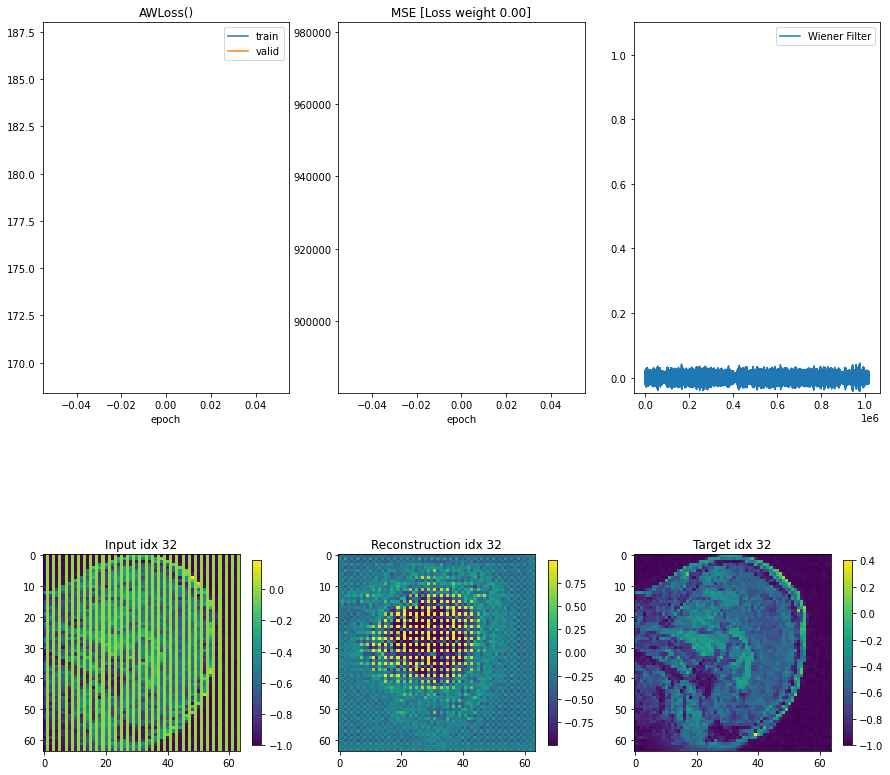

  0% (1 of 1200) |                       | Elapsed Time: 0:00:04 ETA:   1:23:37
  0% (2 of 1200) |                       | Elapsed Time: 0:00:07 ETA:   1:04:43
  0% (3 of 1200) |                       | Elapsed Time: 0:00:10 ETA:   1:05:20
  0% (4 of 1200) |                       | Elapsed Time: 0:00:13 ETA:   1:04:57
  0% (5 of 1200) |                       | Elapsed Time: 0:00:17 ETA:   1:01:17
  0% (6 of 1200) |                       | Elapsed Time: 0:00:20 ETA:   1:02:23
  0% (7 of 1200) |                       | Elapsed Time: 0:00:23 ETA:   1:03:54
  0% (8 of 1200) |                       | Elapsed Time: 0:00:26 ETA:   1:04:35
  0% (9 of 1200) |                       | Elapsed Time: 0:00:29 ETA:   1:05:39
  0% (10 of 1200) |                      | Elapsed Time: 0:00:33 ETA:   1:04:00
  0% (11 of 1200) |                      | Elapsed Time: 0:00:36 ETA:   1:00:22
  1% (12 of 1200) |                      | Elapsed Time: 0:00:39 ETA:   1:00:43
  1% (13 of 1200) |                     


 {'epoch': 300, 'loss': 143.22613525390625, 'mse (weight 0.00)': tensor(16813.7520, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 8064


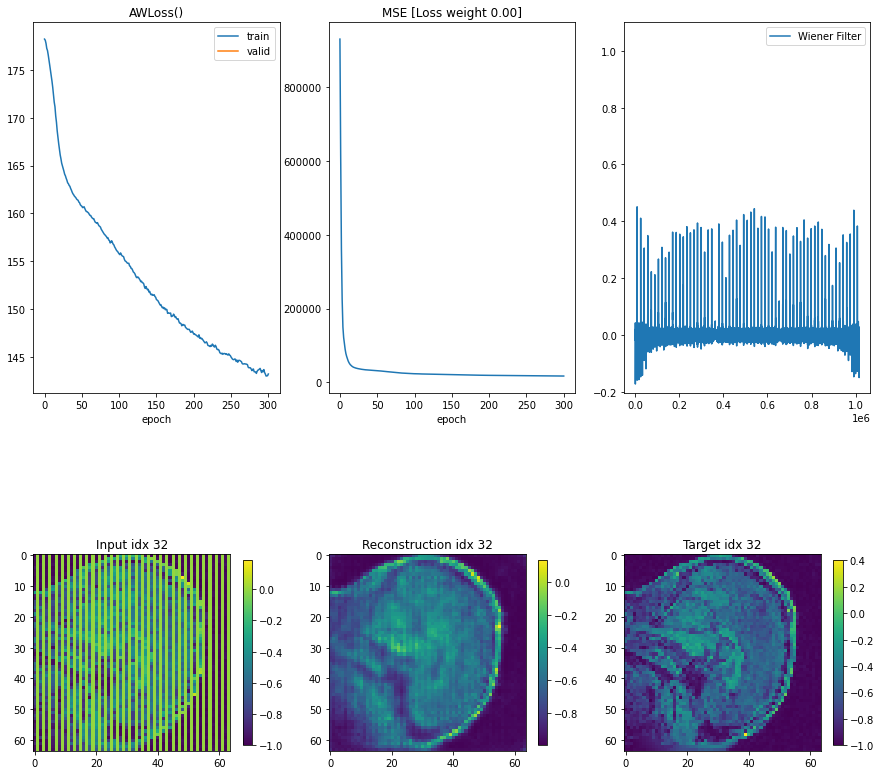

 25% (301 of 1200) |#####                | Elapsed Time: 0:15:59 ETA:   1:03:28
 25% (302 of 1200) |#####                | Elapsed Time: 0:16:02 ETA:   0:48:14
 25% (303 of 1200) |#####                | Elapsed Time: 0:16:06 ETA:   0:47:29
 25% (304 of 1200) |#####                | Elapsed Time: 0:16:09 ETA:   0:47:47
 25% (305 of 1200) |#####                | Elapsed Time: 0:16:12 ETA:   0:47:21
 25% (306 of 1200) |#####                | Elapsed Time: 0:16:15 ETA:   0:46:22
 25% (307 of 1200) |#####                | Elapsed Time: 0:16:18 ETA:   0:48:58
 25% (308 of 1200) |#####                | Elapsed Time: 0:16:22 ETA:   0:48:41
 25% (309 of 1200) |#####                | Elapsed Time: 0:16:25 ETA:   0:48:28
 25% (310 of 1200) |#####                | Elapsed Time: 0:16:28 ETA:   0:48:23
 25% (311 of 1200) |#####                | Elapsed Time: 0:16:31 ETA:   0:47:20
 26% (312 of 1200) |#####                | Elapsed Time: 0:16:35 ETA:   0:46:34
 26% (313 of 1200) |#####               


 {'epoch': 600, 'loss': 136.92645263671875, 'mse (weight 0.00)': tensor(14711.0938, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 56451


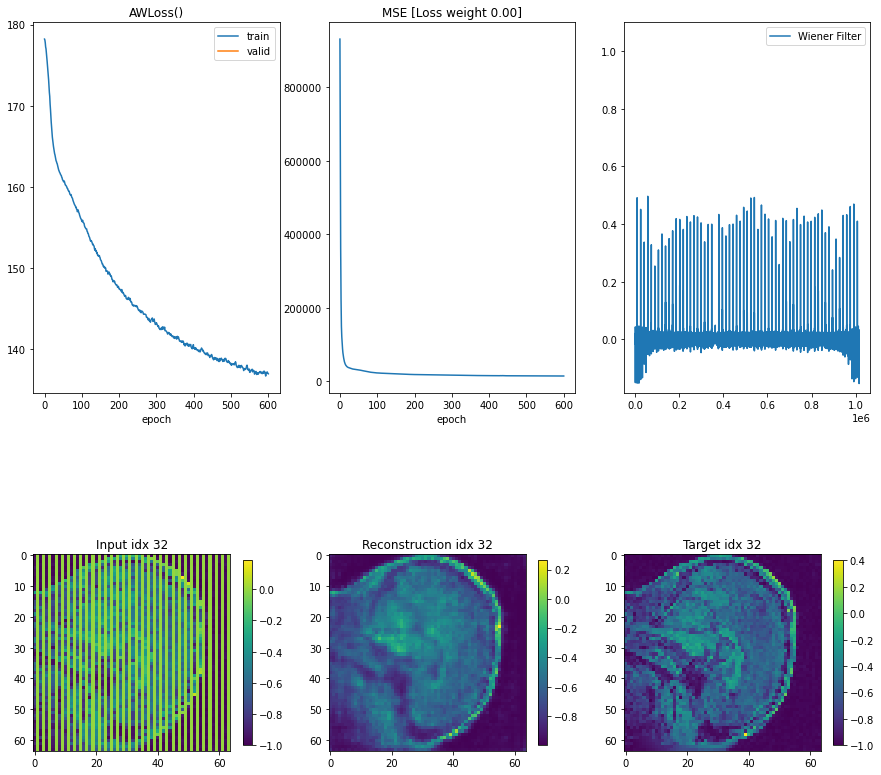

 50% (601 of 1200) |##########           | Elapsed Time: 0:31:55 ETA:   0:42:43
 50% (602 of 1200) |##########           | Elapsed Time: 0:31:58 ETA:   0:31:30
 50% (603 of 1200) |##########           | Elapsed Time: 0:32:01 ETA:   0:32:17
 50% (604 of 1200) |##########           | Elapsed Time: 0:32:04 ETA:   0:33:23
 50% (605 of 1200) |##########           | Elapsed Time: 0:32:08 ETA:   0:31:03
 50% (606 of 1200) |##########           | Elapsed Time: 0:32:11 ETA:   0:31:52
 50% (607 of 1200) |##########           | Elapsed Time: 0:32:14 ETA:   0:32:50
 50% (608 of 1200) |##########           | Elapsed Time: 0:32:17 ETA:   0:31:21
 50% (609 of 1200) |##########           | Elapsed Time: 0:32:21 ETA:   0:31:53
 50% (610 of 1200) |##########           | Elapsed Time: 0:32:24 ETA:   0:31:36
 50% (611 of 1200) |##########           | Elapsed Time: 0:32:27 ETA:   0:30:11
 51% (612 of 1200) |##########           | Elapsed Time: 0:32:30 ETA:   0:30:13
 51% (613 of 1200) |##########          


 {'epoch': 900, 'loss': 133.590576171875, 'mse (weight 0.00)': tensor(13838.9580, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 56451


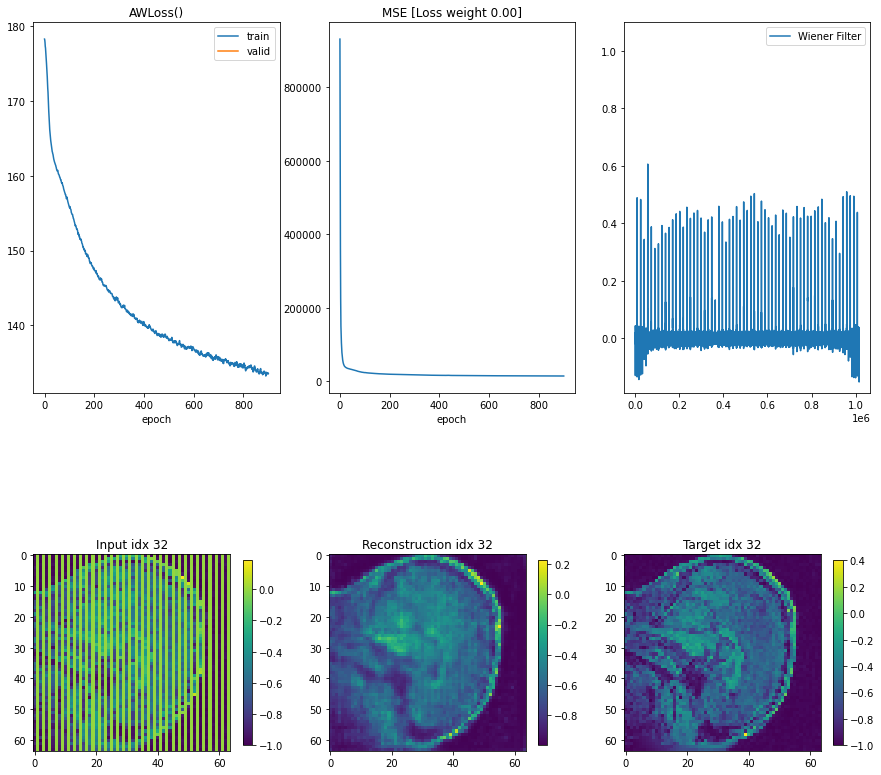

 75% (901 of 1200) |###############      | Elapsed Time: 0:47:51 ETA:   0:20:37
 75% (902 of 1200) |###############      | Elapsed Time: 0:47:54 ETA:   0:15:29
 75% (903 of 1200) |###############      | Elapsed Time: 0:47:57 ETA:   0:15:14
 75% (904 of 1200) |###############      | Elapsed Time: 0:48:01 ETA:   0:16:10
 75% (905 of 1200) |###############      | Elapsed Time: 0:48:04 ETA:   0:15:16
 75% (906 of 1200) |###############      | Elapsed Time: 0:48:07 ETA:   0:15:57
 75% (907 of 1200) |###############      | Elapsed Time: 0:48:10 ETA:   0:15:41
 75% (908 of 1200) |###############      | Elapsed Time: 0:48:14 ETA:   0:15:58
 75% (909 of 1200) |###############      | Elapsed Time: 0:48:17 ETA:   0:16:22
 75% (910 of 1200) |###############      | Elapsed Time: 0:48:20 ETA:   0:14:58
 75% (911 of 1200) |###############      | Elapsed Time: 0:48:23 ETA:   0:14:58
 76% (912 of 1200) |###############      | Elapsed Time: 0:48:26 ETA:   0:15:19
 76% (913 of 1200) |###############     


 {'epoch': 1199, 'loss': 131.4982147216797, 'mse (weight 0.00)': tensor(13343.2070, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 56451


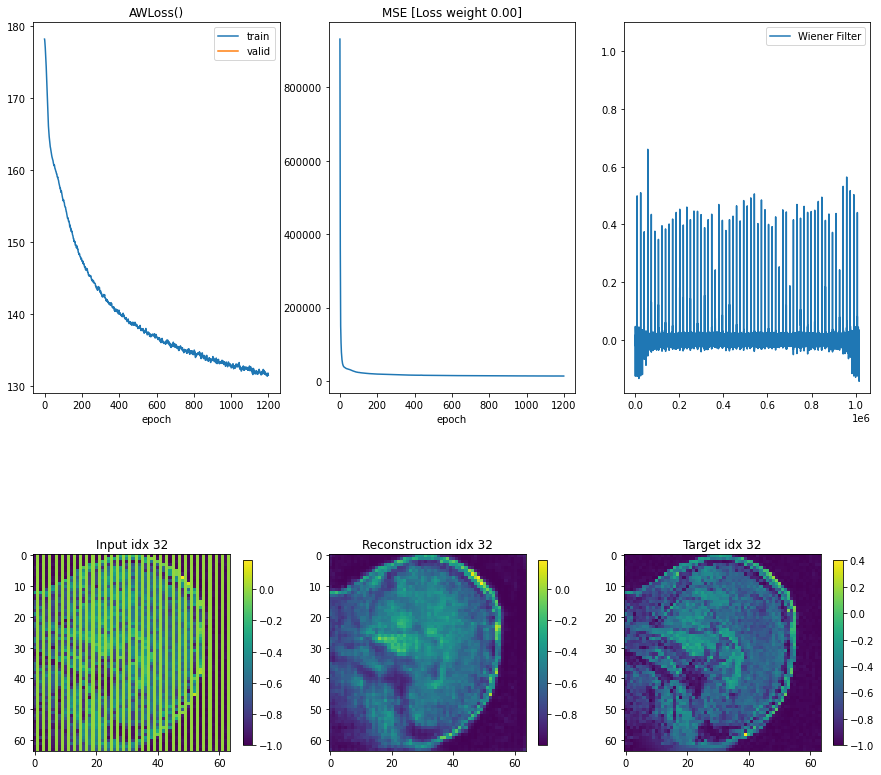

100% (1200 of 1200) |####################| Elapsed Time: 1:03:44 Time:  1:03:44


In [21]:
model = make_model(channels=x_sample.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, awloss, train_loader, wmse=1e-3, valid_loader=None, nepochs=nepochs, log_frequency=300, sample_input=x_sample, sample_target=y_sample, device=device)